Decision trees are widely used since they are easy to interpret, handle categorical features, extend to the multiclass classification setting, do not require feature scaling, and are able to capture non-linearities and feature interactions. Decision trees have a number of parameters that control trade-offs between under vs overfitting. In this notebook, we will explore the effect of tree depth on both training and test set accuracy.

They learn a hierarchy of if/else questions, leading to a decision. This structure is similar to the structure of a decision tree in a flow chart. I believe that if I request you to describe how a thing work, then you will describe it as a flow chart. For example, if you want to classify an animal as a dog or a cat, you may start by asking whether it has a tail or not. If it has a tail, you may further ask whether the ears are pointed or not. If it does not have a tail, you may ask whether it has paws or not. The decision tree can be used to solve both regression and classification problems.

## Building Decision Trees

Learning a decision tree means learning the sequence of if/else questions that gets us to the true answer most quickly. Usually data does not come in the form of binary yes/no features as in the animal example, but is instead represented as continuous features such as the features of the iris dataset shown earlier ?

In [2]:
from sklearn import datasets
import mglearn as mgl
import matplotlib.pyplot as plt

iris = datasets.load_iris()
X = iris.data
y = iris.target

print(iris.keys())
print(iris.feature_names)

dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename', 'data_module'])
['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']


To build a tree, the algorithm searches over all possible tests and finds the one that is most informative about the target variable. The exact way that the search is done depends on the algorithm used. Let's take a look at a simple example, using only two input features and a two-class classification response. The figure below shows a two-dimensional dataset along with the decision boundaries found by a decision tree with maximum depth three, using the scikit-learn library. The background color in each region indicates the class that would be predicted in that region.

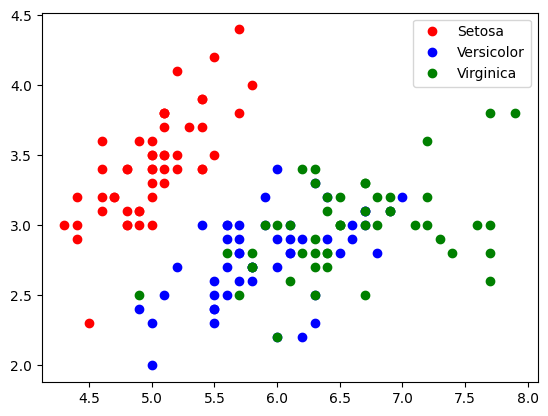

In [3]:
plt.plot(X[:, 0][y == 0], X[:, 1][y == 0], 'ro', label='Setosa')
plt.plot(X[:, 0][y == 1], X[:, 1][y == 1], 'bo', label='Versicolor')
plt.plot(X[:, 0][y == 2], X[:, 1][y == 2], 'go', label='Virginica')
plt.legend()

A prediction on a new data point is made by checking which region of the partition of the feature space the point lies in, and then predicting the majority target (or the single target in the case of pure leaves) in that region. The region can be found by traversing the tree from the root and going left or right, depending on whether the test is fulfilled or not.

It is also possible to use trees for regression tasks, using exactly the same technique. To make a prediction, we traverse the tree based on the tests in each node and find the leaf the new data point falls into. The output for this data point is the mean target of the training points in this leaf

### Controlling complexity of Decision Tree

Typically, building a tree as described here and continuing until all leaves are pure leads to models that are very complex and highly overfit to the training data. The presence of pure leaves mean that a tree is 100% accurate on the training set; each data point in the training set is in a leaf that has the correct majority class.

There're two common strategies to prevent overfitting: stopping the creation of the tree early (pre-pruning), build the tree but removing or collapsing nodes that contain little information (post-pruning or just pruning).

Decision trees in *scikit-learn* are implemented in the **DecisionTreeRegressor** and **DecisionTreeClassifier** classes. scikit-learn only implements pre-pruning, not post-pruning.

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.datasets import load_breast_cancer
import numpy as np
import matplotlib.pyplot as plt

In [5]:
cancer = load_breast_cancer()

In [6]:
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, stratify = cancer.target, random_state = 42)

In [7]:
results = []

for i in range(2,10):
    tree = DecisionTreeClassifier(random_state = 0, max_depth = i)
    tree.fit(X_train, y_train)
    results.append([i, tree.score(X_train, y_train), tree.score(X_test, y_test)])
    print("Tree number:", i)
    print("Accuracy on training set: {:.3f}".format(tree.score(X_train, y_train)))
    print("Accuracy on test set: {:.3f}".format(tree.score(X_test, y_test)))

Tree number: 2
Accuracy on training set: 0.958
Accuracy on test set: 0.909
Tree number: 3
Accuracy on training set: 0.977
Accuracy on test set: 0.944
Tree number: 4
Accuracy on training set: 0.988
Accuracy on test set: 0.951
Tree number: 5
Accuracy on training set: 0.995
Accuracy on test set: 0.951
Tree number: 6
Accuracy on training set: 0.998
Accuracy on test set: 0.937
Tree number: 7
Accuracy on training set: 1.000
Accuracy on test set: 0.937
Tree number: 8
Accuracy on training set: 1.000
Accuracy on test set: 0.937
Tree number: 9
Accuracy on training set: 1.000
Accuracy on test set: 0.937


As expected, the accuracy on the training set is 100% (max depth), because the leaves are pure, the tree was grown deep enough that it could perfectly memorize all the labels on the training data.

If we don't restrict the depth of a tree, it can be deep and complex. Un-pruned trees are therefore prone to overfitting and not generalizing well to new data. That why when I loop through a list of depth, it giving the best results at depth 5 and 6.

### Analyzing Decision Trees

The main benefit of decision trees is that they are easy to understand and interpret. The tree can be visualized using the export_graphviz function from the tree module. This writes a file in the .dot file format, which is a text file format for storing graphs. We set an option to color the nodes to reflect the majority class in each node and pass the class and features names so the tree can be properly labeled.

In [8]:
from sklearn.tree import export_graphviz
export_graphviz(tree, out_file = "data/tree.dot", class_names = ["malignant", "benign"], feature_names = cancer.feature_names, impurity = False, filled = True)

We can read this using graphviz module:

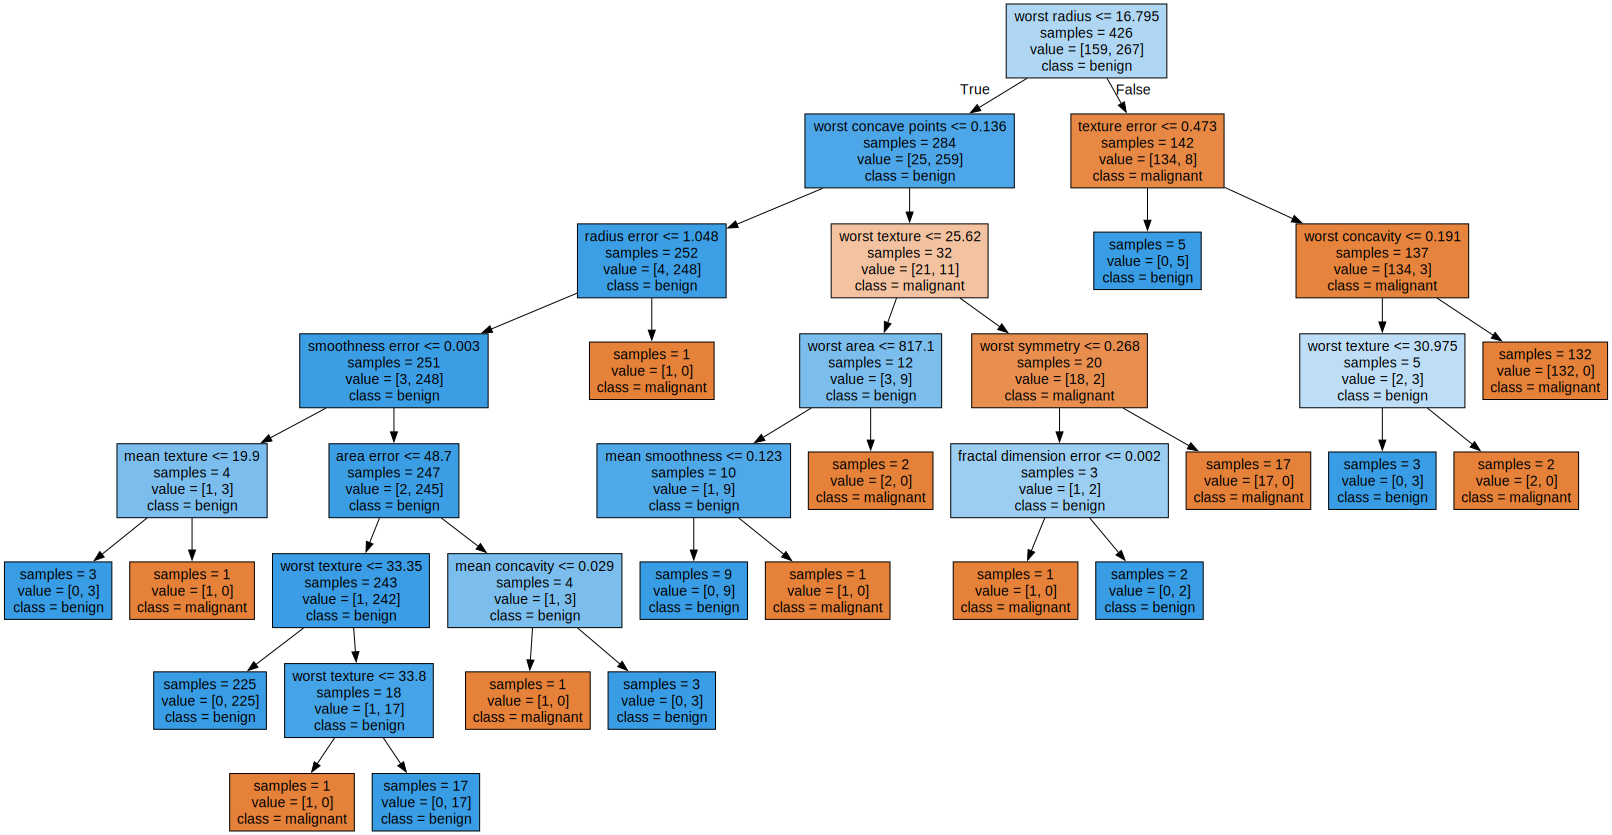

In [9]:
import graphviz

with open("data/tree.dot") as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)

The visualization of the tree provides a great in-depth view of how the algorithm makes predictions, and is a good example of a machine learning algorithm that is easily explained to non-experts. However, even with a tree of depth four, as seen here, the tree can become a bit overwhelming. Deeper trees (a depth of 10 is not uncommon) are even harder to grasp. One method of inspecting the tree that may be helpful is to find out which path most of the data actually takes.

## Feature Importance in Trees

Instead of looking at the whole tree, which can be taxing, there are some useful properties that we can derive to summarize the workings of the tree. The most commonly used summary is feature importance, which rates how important each feature is for the decision a tree makes. It is a number between 0 and 1 for each feature, where 0 means “not used at all” and 1 means “perfectly predicts the target.” The feature importances always sum to 1

In [10]:
print("Feature importances:\n{}".format(tree.feature_importances_))

Feature importances:
[0.         0.00752597 0.         0.         0.00903116 0.
 0.00752597 0.         0.         0.         0.00975731 0.04630969
 0.         0.00238745 0.00231135 0.         0.         0.
 0.         0.00668975 0.69546322 0.05383211 0.         0.01354675
 0.         0.         0.01740312 0.11684357 0.01137258 0.        ]


So we can visualize the feature importance and see which feature is important and which is not.

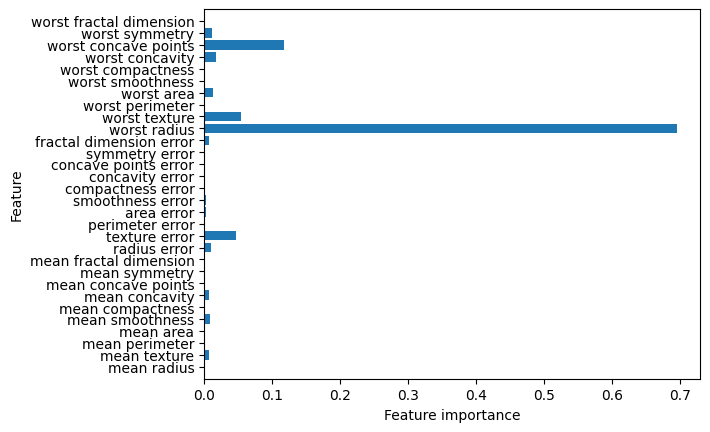

In [11]:
def plot_feature_importances_cancer(model):
    n_features = cancer.data.shape[1]
    plt.barh(range(n_features), model.feature_importances_, align = 'center')
    plt.yticks(np.arange(n_features), cancer.feature_names)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    plt.ylim(-1, n_features)
    
plot_feature_importances_cancer(tree)

Here we see that the feature used in the top ("Worst Radius") is by far the most important feature. This confirms our observation in analyzing the tree that the first level already separates the two classes fairly well.

However, if a feature has a low feature_importance, it doesn’t mean that this feature is uninformative. It only means that the feature was not picked by the tree, likely because another feature encodes the same information

Feature importances: [0. 1.]


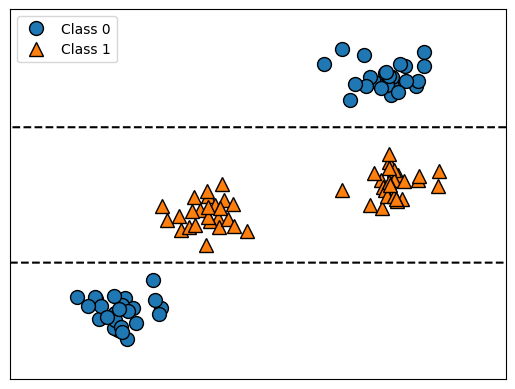

In [12]:
import mglearn as mgl
tree = mgl.plots.plot_tree_not_monotone()
plt.show()

While we focused our discussion here on decision trees for classification, all that was said is similarly true for decision trees for regression, as implemented in *DecisionTreeRegressor*. The usage and analysis of regression trees is very similar to that of classification trees. There is one particular property of using tree-based models for regression that we want to point out, though. The *DecisionTreeRegressor* (and all other tree-based regression models) is not able to extrapolate, or make predictions outside of the range of the training data

Text(0, 0.5, 'Price in $/Mbyte')

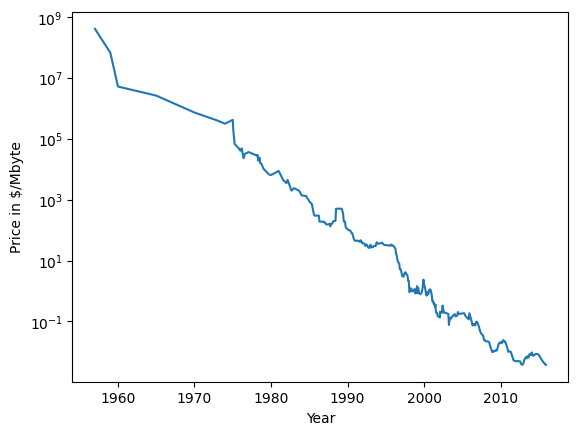

In [13]:
import pandas as pd
ram_prices = pd.read_csv("data/ram_price.csv")

plt.semilogy(ram_prices.date, ram_prices.price)
plt.xlabel("Year")
plt.ylabel("Price in $/Mbyte")

In [20]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
import numpy as np

data_train = ram_prices[ram_prices.date < 2000]
data_test = ram_prices[ram_prices.date >= 2000]

X_train = np.array(ram_prices.date)[:, np.newaxis] 
y_train = np.log(ram_prices.price)

X_all = np.array(ram_prices.date)[:, np.newaxis]

tree = DecisionTreeRegressor().fit(X_train, y_train)
linear_reg = LinearRegression().fit(X_train, y_train)

pred_tree = tree.predict(X_all)
pred_lr = linear_reg.predict(X_all)

price_tree = np.exp(pred_tree)
price_lr = np.exp(pred_lr)

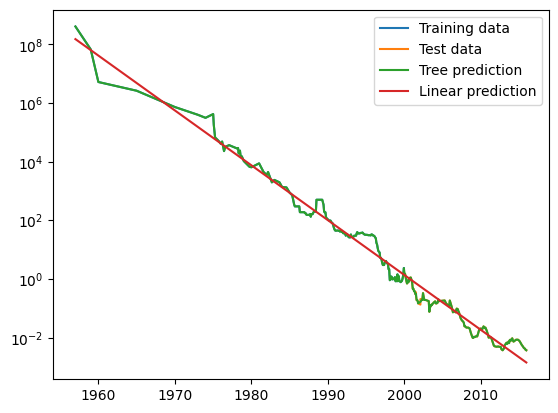

In [21]:
plt.semilogy(data_train.date, data_train.price, label="Training data")
plt.semilogy(data_test.date, data_test.price, label="Test data")
plt.semilogy(ram_prices.date, price_tree, label="Tree prediction")
plt.semilogy(ram_prices.date, price_lr, label="Linear prediction")
plt.legend()

The difference between the models is quite striking.

## Ensemble of Decision Trees

### Random Forests

Random forests are one of the most widely used machine learning methods. They are a powerful method that can be used for both classification and regression tasks. As we saw earlier, a single decision tree is prone to overfitting because it can keep branching until it memorizes the training set. A random forest is essentially a collection of decision trees, where each tree is slightly different from the others. The idea behind random forests is that each tree might do a relatively good job of predicting, but will likely overfit on part of the data. If we build many trees, all of which work well and overfit in different ways, we can reduce the amount of overfitting by averaging their results.

**Building random forests**

To build a random forest model, you need to decide on the number of trees to build (the n_estimators parameter of RandomForestRegressor or RandomForestClassifier).

There are two ways to control the tree growth: by limiting the maximum depth of the trees via the max_depth parameter, or by limiting the maximum number of leaves via the max_leaf_nodes parameter. Intuitively, a larger number of trees should lead to a smoother decision boundary, as we are averaging more estimates. A smaller number of trees will lead to a more complex decision boundary, fitting the training set more closely.

A new decision tree is built based on a bootstrap sample drawn from the training set. That is, a number of data points equal to the number of data points in the training set is drawn with replacement. This means that some data points might be drawn multiple times for the same tree. The bootstrap sample will be the training set for growing the tree. However, each time a split is considered, a random sample of features is drawn as candidates for splitting. The number of features that are drawn is controlled by the max_features parameter. The best split is found among those features.

A high *max_features* means that the trees in the random forest will be quite similar, and they will fit the data closely. A low *max_features* means that the trees in the random forest will be quite different, and that each tree might be able to fit just part of the data, capturing more of the true signal. Increasing *max_features* might lead to better performance on the training set, but it can also decrease the diversity of the trees, and therefore increase the overfitting.

In [22]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_moons

X, y = make_moons(n_samples = 100, noise = 0.25, random_state = 3)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, random_state = 42)

forest = RandomForestClassifier(n_estimators = 5, random_state = 2)
forest.fit(X_train, y_train)

RandomForestClassifier(n_estimators=5, random_state=2)

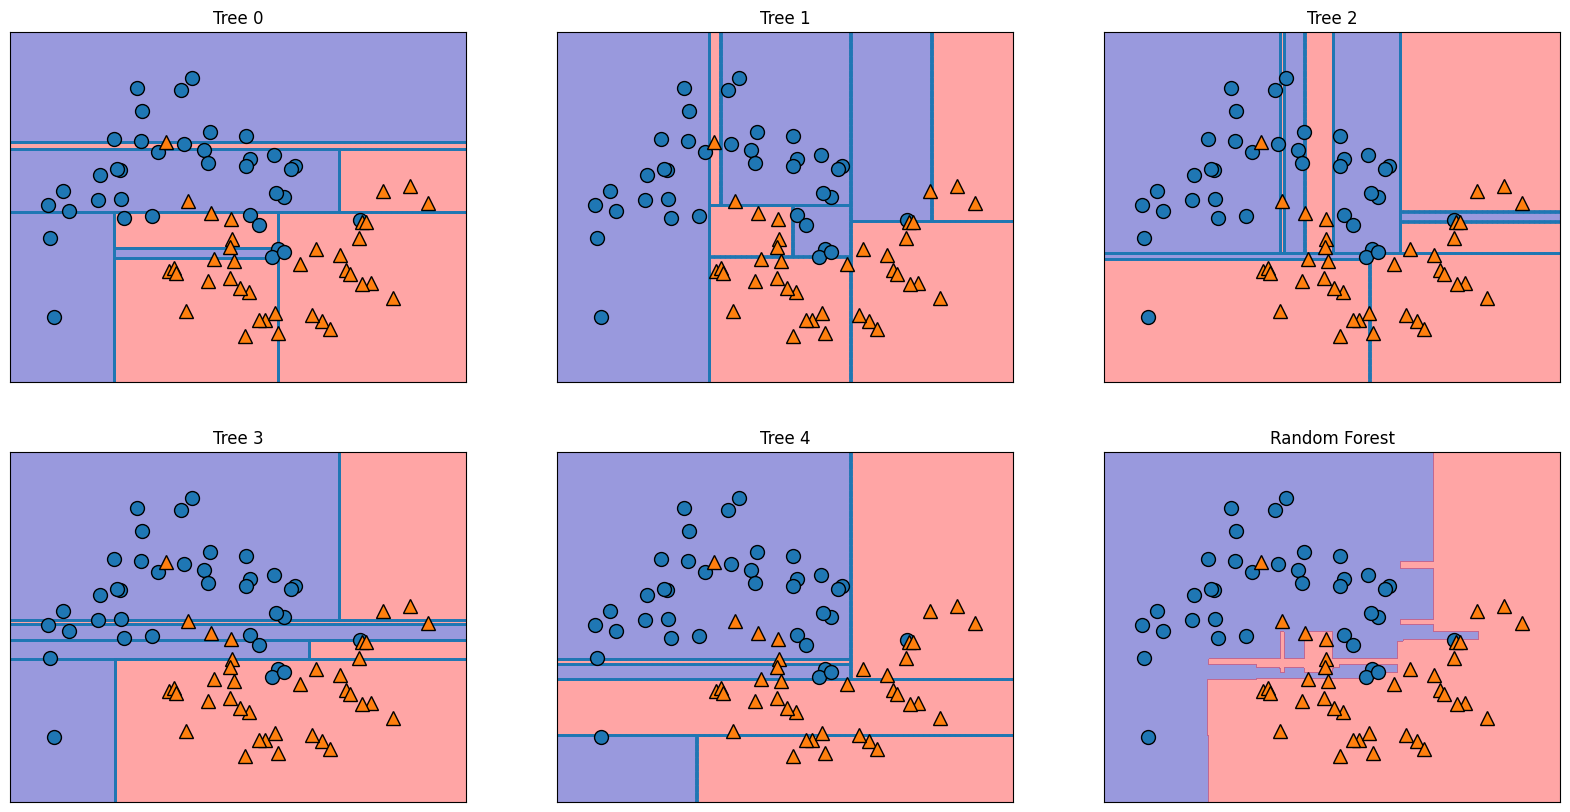

In [23]:
fig, axes = plt.subplots(2, 3, figsize = (20, 10))
for i, (ax, tree) in enumerate(zip(axes.ravel(), forest.estimators_)):
    ax.set_title("Tree {}".format(i))
    mgl.plots.plot_tree_partition(X_train, y_train, tree, ax = ax)

mgl.plots.plot_2d_separator(forest, X_train, fill = True, ax = axes[-1, -1], alpha = .4)
axes[-1, -1].set_title("Random Forest")
mgl.discrete_scatter(X_train[:, 0], X_train[:, 1], y_train)

We can clearly see that the decision boundaries learned by the five trees are quite different. The randomness in building the random forest forces each tree to be different from all others. The drawback of this is that the trees in the forest will be quite correlated. Therefore, the trees won’t be able to learn from each other, and on average, will be making the same types of errors. Combining these trees results in a smoother and more general decision boundary.

In [24]:
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, random_state=0)
forest = RandomForestClassifier(n_estimators=100, random_state=0)
forest.fit(X_train, y_train)
print("Accuracy on training set: {:.3f}".format(forest.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(forest.score(X_test, y_test)))

Accuracy on training set: 1.000
Accuracy on test set: 0.972


100% accuracy on the training set and 97% accuracy on the test set. This is much better than the linear models or a single decision tree, without tuning any parameters. We could still try to adjust the *max_features* setting, perform more or less pre-pruning, or adjust *max_depth* to improve the results.

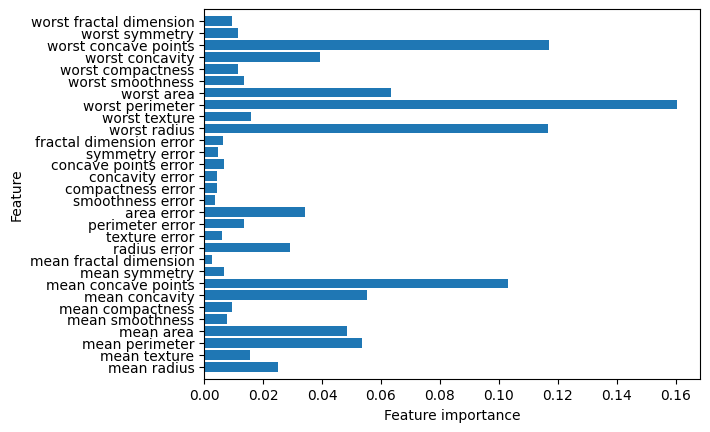

In [25]:
plot_feature_importances_cancer(forest)

The random forest gives nonzero importance to many more features than the single tree. Similarly to the single decision tree, the random forest also gives a lot of importance to the "worst radius" feature, but it actually chooses "worst perimeter" to be the most informative feature overall

**Pros and Cons of Decision Trees**

Random forest in both task are currently among the most widely used machine learning methods. They're very powerful, often work well without heavy tuning of the parameters, and don't require scaling of the data. The main downside of random forests is that the results are not easily interpretable. If you would like to have a model that is easily interpretable, using a single decision tree or a small number of decision trees might be a better choice. The model don't tend to work well on very high dimensional, sparse data, such as text data. For this kind of data, linear models might be more appropriate.

The *n_job* parameter controls how many cores scikit-learn will use for training and predicting with a random forest. By setting *n_jobs=-1*, scikit-learn will use all available cores on your computer. If you set *n_jobs=1*, scikit-learn will only use one core. Using more cores will speed up the training, but also use more memory. If your computer freezes or becomes very slow when you run a grid search or another scikit-learn operation, setting *n_jobs=-1* might help.

The *random_state* parameter controls the randomness of the forest. The randomness is used in two ways: first, when building the trees, and second, when splitting nodes. To obtain a deterministic behavior during fitting, *random_state* has to be fixed to an integer. That way, each time you run the random forest with the same value for *random_state*, you will always get the same result.

The important parameters to adjust are *n_estimators*, *max_features*, and possibly *pre-pruning* options like *max_depth*. For *n_estimators*, larger is always better. Averaging more trees will yield a more robust ensemble by reducing overfitting. However, there are diminishing returns, and more trees need more memory and more time to train. A common rule of thumb is that *max_features=sqrt(n_features)* (or *max_features=log2(n_features)* for classification) leads to good performance.

### Gradient Boosted Regression Trees (Gradient Boosting Machines)

The gradient boosted regression tree is another ensemble method that combines multiple decision trees to create a more powerful model. Despite the "regression" in the name, these models can be used for **regression and classification**. In contrast to the random forest approach, gradient boosting works by building trees in a serial manner, where each tree tries to correct the mistakes of the previous one. By default, there is no randomization in gradient boosted regression trees; instead, strong pre-pruning is used. Gradient boosted trees often use very shallow trees, of depth one to five, which makes the model smaller in terms of memory and makes predictions faster.

The main idea behind gradient boosting is to combine many simple models (in this context known as weak learners), like shallow trees. Each tree can only provide good predictions on part of the data, and so more and more trees are added to iteratively improve performance.

Apart from the pre-pruning and the number of trees in the ensemble, another important parameter of gradient boosting is the *learning_rate*, which controls how strongly each tree tries to correct the mistakes of the previous trees. A higher learning rate means each tree can make stronger corrections, allowing for more complex models.

In [26]:
from sklearn.ensemble import GradientBoostingClassifier

X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, random_state = 0)

gbrt = GradientBoostingClassifier(random_state = 0)
gbrt.fit(X_train, y_train)

print("Accuracy on training set: {:.3f}".format(gbrt.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(gbrt.score(X_test, y_test)))

Accuracy on training set: 1.000
Accuracy on test set: 0.965


As the training set accuracy is 100%, we are likely to be overfitting. To reduce overfitting, we could either apply stronger pre-pruning by limiting the maximum depth or lower the learning rate:

In [32]:
gbrt_md = GradientBoostingClassifier(random_state = 0, max_depth = 1)
gbrt_md.fit(X_train, y_train)

print("Accuracy on training set: {:.3f}".format(gbrt_md.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(gbrt_md.score(X_test, y_test)))

Accuracy on training set: 0.991
Accuracy on test set: 0.972


In [33]:
gbrt_lr = GradientBoostingClassifier(random_state = 0, learning_rate = 0.01)
gbrt_lr.fit(X_train, y_train)

print("Accuracy on training set: {:.3f}".format(gbrt_lr.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(gbrt_lr.score(X_test, y_test)))

Accuracy on training set: 0.988
Accuracy on test set: 0.958


As we can see, lowering the maximum depth of the trees provided a significant improvement of the model, while lowering the learning rate only increased the generalization performance slightly

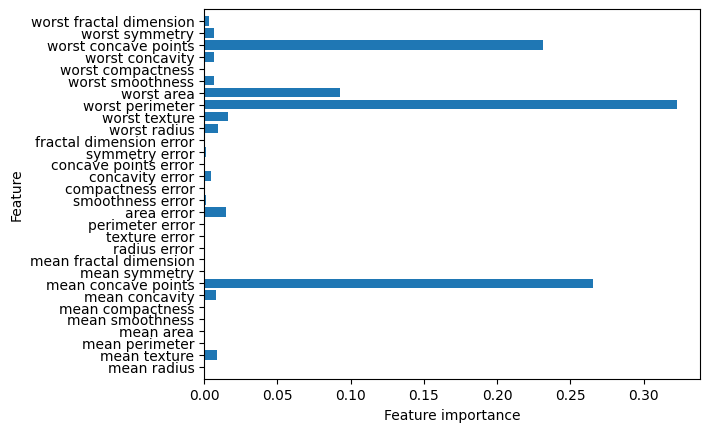

In [34]:
plot_feature_importances_cancer(gbrt_md)

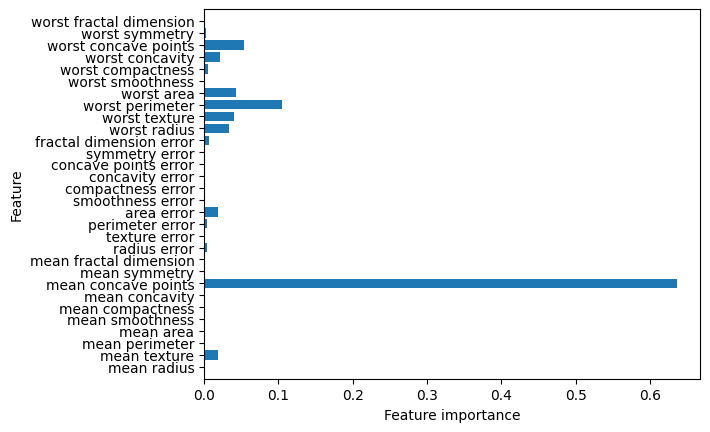

In [35]:
plot_feature_importances_cancer(gbrt_lr)

**Pros and Cons of Gradient Boosted Regression Trees**

Gradient boosted decision trees are among the most powerful and widely used models for supervised learning. Their main drawback is that they require careful tuning of the parameters and may take a long time to train. Similarly to other tree-based models, the algorithm works well without scaling and on a mixture of binary and continuous features. As with other tree-based models, it also often does not work well on high-dimensional sparse data.

The main *n_estimators* and *learning_rate* parameters control the complexity of the gradient boosted decision tree ensemble. Usually, a grid search is done over only *n_estimators*, then *learning_rate* is set to a fixed value. A lower *learning_rate* means more trees have to be built to achieve the same level of complexity. In contrast to random forests, where a higher *n_estimators* value is always better, increasing *n_estimators* in gradient boosting leads to a more complex model, which may lead to overfitting. A common practice is to fit *n_estimators* depending on the time and memory budget, and then search over different *learning_rate* values.

Another important parameter is *max_depth* (or alternatively *max_leaf_nodes*), to reduce the complexity of each tree. Usually max_depth is set very low for gradient boosted models, often not deeper than five splits.

Next, we will look at a different kind of model, called *kernelized support vector machines* or Support Vector Machine